In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.plot import show
import numpy as np

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
path_shp_cat = r'C:\Documents\OneDrive - Ingenio Azucarero Guabira S.A\INFORMACION GENERAL\CATASTRO\NUEVO\CATASTRO.shp'
gdf_cat = gpd.read_file(path_shp_cat)
gdf_prop = gdf_cat[gdf_cat['unidad_01']==30]
gdf_prop = gdf_prop[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'geometry']]

In [3]:
gdf_prop.head(3)

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,geometry
608,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L26,44.606623,"POLYGON ((500070.322 8095568.798, 500053.889 8..."
609,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L2,22.961028,"POLYGON ((500165.099 8095280.914, 500742.525 8..."
610,30.0,CAMPO DULCE,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L30,27.634199,"POLYGON ((499189.807 8095282.481, 499247.624 8..."


In [4]:
def generar_plano(shp_prop, path_tif, path_out):
    # Cargar la imagen TIFF con rasterio
    with rasterio.open(path_tif) as src:
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]  # Límites geoespaciales
        img = src.read([1, 2, 3])  # Leer las bandas RGB
        
        # Apply contrast stretching
        #if img.dtype != np.uint8:
            #img = stretch_contrast(img)  
    
    # Crear el plano
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Mostrar la imagen de fondo (TIFF) con coordenadas georreferenciadas
    show(img, transform=src.transform, ax=ax)
    
    #facecolor=(R, G, B, Alpha)
    shp_prop.plot(ax=ax, edgecolor='red', facecolor=(0, 0, 0, 0), linewidth=1)

    # Agregar etiquetas con lote mas area
    for idx, row in shp_prop.iterrows():
        if row.geometry is not None:
            label = f"{row['unidad_05']}\n{round(row['area'], 2)} ha"
            centroid = row.geometry.representative_point()  # Mejor que .centroid en algunos casos
            ax.text(centroid.x, centroid.y, label, fontsize=7, ha='center', color='black', weight=1000,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.2, pad=0))

    # Configurar título
    nom_prop = shp_prop["unidad_02"].iloc[0]
    ax.set_title(nom_prop, fontsize=14)

    # 🔍 **Ajustar los límites del mapa para hacer zoom en la propiedad**
    bounds = shp_prop.total_bounds  # [xmin, ymin, xmax, ymax]
    ax.set_xlim([bounds[0] - 400, bounds[2] + 400])
    ax.set_ylim([bounds[1] - 400, bounds[3] + 400])

    # 🔹 **Agregar Leyenda**
    legend_elements = [
        #facecolor=(R, G, B, Alpha)
        Patch(facecolor=(0, 0, 0, 0), edgecolor='red', label='Lotes'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, frameon=True, facecolor='white', edgecolor='black')

    # Guardar plano
    fig.savefig(path_plano, dpi = 300, bbox_inches='tight')
    
    # Mostrar el mapa
    #plt.show()

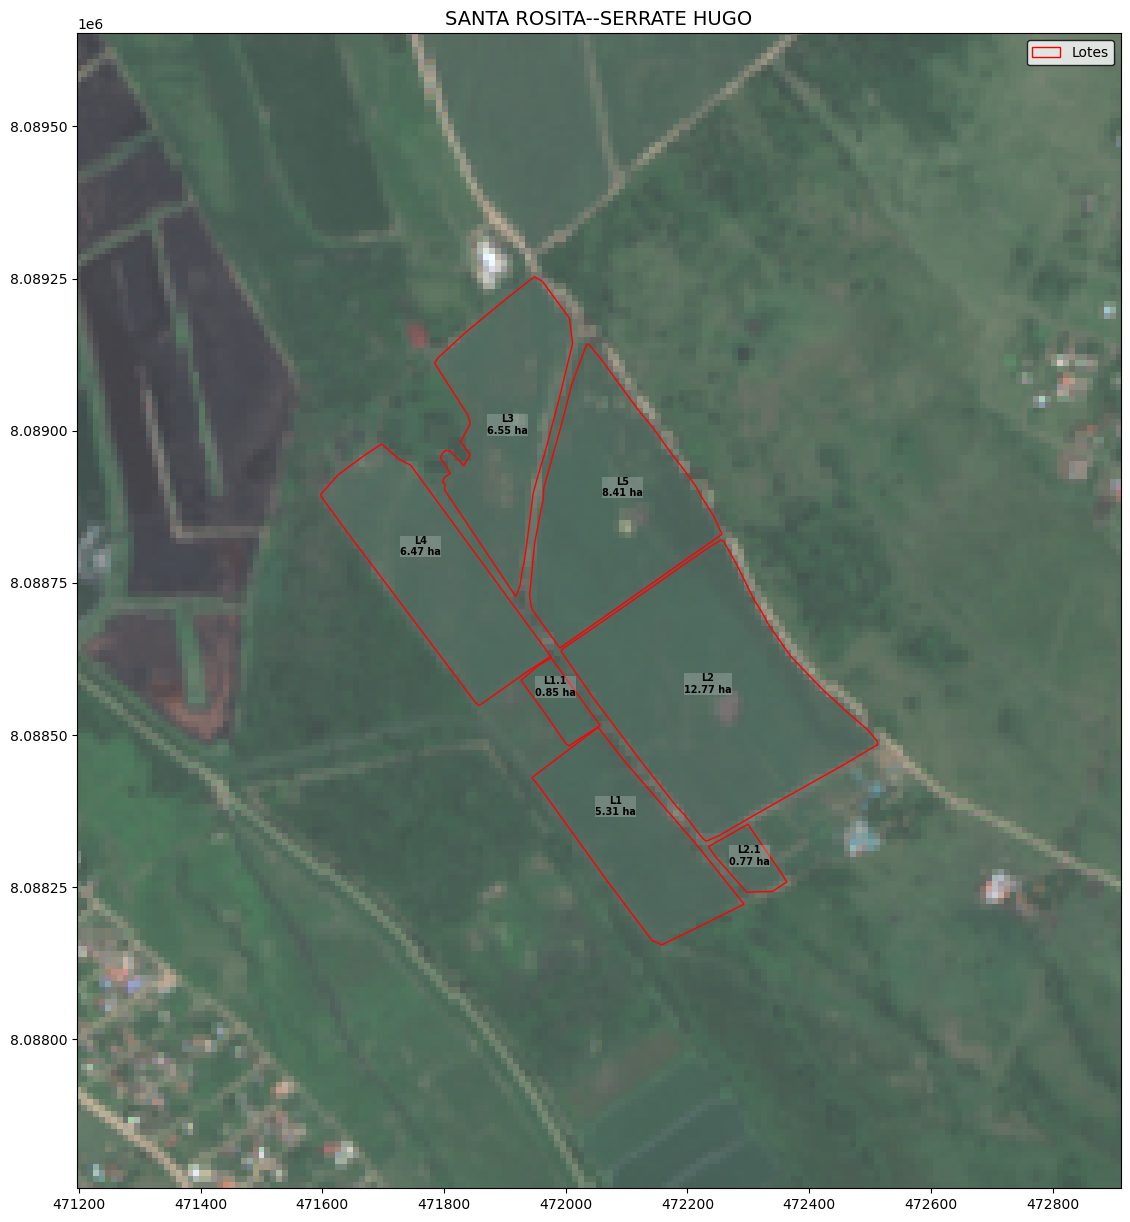

In [5]:
#path_tif = r"C:\Users\bismarksr\Downloads\Imagen_Real_RGB.tif"
path_tif = r"C:\Users\bismarksr\Downloads\SENTINEL_2025-02-12_UTM_2.tif"
path_plano = r"C:\Users\bismarksr\Downloads\plano_30.jpg"

prop = gdf_cat[gdf_cat['unidad_01']==1892]
generar_plano(prop, path_tif, path_plano)

# Reproyectar RGB raster de WGS874 a UTM 20S

In [9]:
# Función para mejorar el contraste
def stretch_contrast(img, p_low=2, p_high=99.9):
    """Mejora el contraste ajustando los valores de los píxeles entre percentiles."""
    img_stretched = np.zeros_like(img, dtype=np.uint8)
    
    for i in range(img.shape[0]):  # Iterar sobre las bandas (R, G, B)
        low, high = np.percentile(img[i], [p_low, p_high])  # Calcular percentiles
        img_stretched[i] = np.clip((img[i] - low) / (high - low) * 255, 0, 255)  # Normalizar
    
    return img_stretched.astype(np.uint8)

In [10]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np

# Ruta de la imagen original y la nueva imagen reproyectada
path_tif = r"C:\Users\bismarksr\Downloads\SENTINEL_2025-07-26.tif"
path_tif_utm = r"C:\Users\bismarksr\Downloads\SENTINEL_2025-07-26_UTM.tif"

# Definir CRS de destino (UTM 20S - EPSG 32720)
dst_crs = "EPSG:32720"

# Abrir la imagen original
with rasterio.open(path_tif) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)

    # Configurar los metadatos del nuevo archivo
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height,
        "dtype": "uint8"  # Asegurar que se guarde como uint8 después del contraste
    })

    # Crear la imagen reproyectada
    with rasterio.open(path_tif_utm, "w", **kwargs) as dst:
        for i in range(1, src.count + 1):  # Iterar sobre las bandas
            # Crear un array vacío para la banda reproyectada
            band_reprojected = np.empty((height, width), dtype=src.dtypes[i - 1])

            # Reproyectar la banda
            reproject(
                source=rasterio.band(src, i),
                destination=band_reprojected,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )

            # Aplicar mejora de contraste solo si la banda no es uint8
            if band_reprojected.dtype != np.uint8:
                band_reprojected = stretch_contrast(np.expand_dims(band_reprojected, axis=0)).squeeze()

            # Escribir la banda en el archivo de salida
            dst.write(band_reprojected, i)

# Reproyectar NDVI

In [3]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np

# Ruta del archivo original y de salida
path_tif = r"C:\Users\bismarksr\Downloads\NDVI_02_2025.tif"
path_tif_utm = r"C:\Users\bismarksr\Downloads\NDVI_02_2025_UTM.tif"

# Definir el CRS de destino (ejemplo: UTM 20S - EPSG 32720)
dst_crs = "EPSG:32720"

# Abrir el raster original
with rasterio.open(path_tif) as src:
    # Calcular la nueva transformación, tamaño y resolución en UTM
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )

    # Crear metadatos para la nueva imagen
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": dst_crs,  # Asignar el nuevo CRS
        "transform": transform,
        "width": width,
        "height": height
    })

    # Abrir el archivo de salida
    with rasterio.open(path_tif_utm, "w", **kwargs) as dst:
        for i in range(1, src.count + 1):  # Iterar sobre cada banda
            # Crear un array vacío para la banda reproyectada
            band_reprojected = np.empty((height, width), dtype=src.dtypes[i - 1])

            # Reproyectar la banda
            reproject(
                source=rasterio.band(src, i),  # Fuente (banda original)
                destination=band_reprojected,  # Destino (banda reproyectada)
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.bilinear  # Método de remuestreo
            )

            # Guardar la banda reproyectada en el nuevo archivo
            dst.write(band_reprojected, i)
